In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [3]:
def sample_distances(distance_file, n):
    # Read only the 4th and 8th columns from the file
    distances = pd.read_csv(distance_file, sep='\t', usecols=[3, 7], header=None, names=['TF', 'Distance'])
    
    # Sample n or all, if less than n, instances
    return distances.sample(n=min(n, len(distances)), random_state=1)


In [5]:
def get_significance_stars(p_value):
    """
    Return significance stars based on the p-value.
    """
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''

In [6]:
def add_stat_annotation(ax, x1, x2, y, p_value, significance_stars, col_name):
    """
    Add a line and significance stars between two boxes on the plot.
    """
    line_y = y + 0.05 * y  # Offset for line above the box
    ax.plot([x1, x1, x2, x2], [y, line_y, line_y, y], lw=1.5, color='black')
    ax.text((x1 + x2) * 0.5, line_y, significance_stars, ha='center', va='bottom', color=col_name, fontsize=12)


In [29]:
def plot_distances(sampled_data, tf_preferences, output_folder, plot_type='boxplot'):
    """
    Plot distributions of distances for TFs, colored by their class, with p-value annotations.

    Parameters:
    - sampled_data: DataFrame containing the distances with TFs and their classes.
    - tf_preferences: DataFrame containing TF preferences and their corresponding classes.
    - output_folder: Path to the folder where the plots will be saved.
    - plot_type: Type of plot to create ('boxplot' or 'violinplot').
    """
    # Rename Class column in tf_preferences for clarity
    tf_preferences = tf_preferences.rename(columns={'Class': 'Class_from_pref'})

    # Merge sampled_data with tf_preferences to get the group (Class) information
    merged_data = sampled_data.merge(tf_preferences[['TF', 'Class_from_pref']], on='TF', how='left')

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Plotting
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    sns.boxplot(x='Class_from_pref', y='Distance', hue='Class_from_pref', data=merged_data, palette='Set2', showfliers=False)

    # Perform statistical tests and annotate with p-values
    unique_groups = merged_data['Class_from_pref'].unique()

    # add the box positions according to unique preference classes
    uniq_classes = []
    box_positions = [0, 1, 2 ] 
    y_group = merged_data['Distance'].max() / 35
    gap_increment = (y_group / 10)  

    current_y = y_group
    for i, g1 in enumerate(unique_groups):
        for j, g2 in enumerate(unique_groups):
            if i < j:  # Compare each pair of TFs only once
                g1_data = merged_data[merged_data['Class_from_pref'] == g1]
                g2_data = merged_data[merged_data['Class_from_pref'] == g2]
                
                g1_distances = g1_data['Distance']
                g2_distances = g2_data['Distance']

                # Perform t-test
                stat, p_value = ttest_ind(g1_distances, g2_distances, equal_var=False)

                # Get significance stars based on p-value
                stars = get_significance_stars(p_value)
                if stars:  # Only annotate significant comparisons
                    add_stat_annotation(ax, box_positions[i], box_positions[j], current_y, p_value, stars, "red")
                    current_y += gap_increment

    plt.title(f'Class-wise Distribution of Distances ({plot_type.capitalize()})')
    ax.set_xlabel('Preference Class', fontsize=16)  # X-axis label font size
    ax.set_ylabel('Distance', fontsize=16)  # Y-axis label font size

    # Adjust tick label font size
    ax.tick_params(axis='x', labelsize=14)  # X-axis tick labels font size
    ax.tick_params(axis='y', labelsize=14)
    plt.xticks(rotation=60, ha='right')

    # Save the figure
    plt.savefig(os.path.join(output_folder, f'TF_distribution_{plot_type}.png'), bbox_inches="tight", dpi=600)
    plt.close()

    print(f'{plot_type.capitalize()} plot saved to {output_folder}')

In [9]:
def write_distance_statistics(sampled_data, tf_preferences, output_folder, n_instances, distance_type='first'):
    """
    Write statistics of distances for groups of TFs to a text file.

    Parameters:
    - sampled_data: DataFrame containing the sampled distances with TFs and their classes.
    - tf_preferences: DataFrame containing TF preferences and their corresponding classes.
    - output_folder: Path to the folder where the statistics file will be saved.
    - distance_type: Type of distances being analyzed ('first' or 'second').
    """
    # Rename Class column in tf_preferences for clarity
    tf_preferences = tf_preferences.rename(columns={'Class': 'Class_from_pref'})

    # Merge sampled_data with tf_preferences to get the group (Class) information
    merged_data = sampled_data.merge(tf_preferences[['TF', 'Class_from_pref']], on='TF', how='left')

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Calculate statistics for each class
    stats = merged_data.groupby('Class_from_pref')['Distance'].describe().reset_index()

    # Rename columns for clarity
    stats.rename(columns={
        'count': 'Count',
        'mean': 'Mean',
        'std': 'StdDev',
        'min': 'Min',
        '25%': 'Q1',
        '50%': 'Median',
        '75%': 'Q3',
        'max': 'Max'
    }, inplace=True)

    # Define output file name based on distance type
    output_file = os.path.join(output_folder, f'{distance_type}_{n_instances}_distance_statistics.txt')

    # Write the statistics to a text file
    with open(output_file, 'w') as f:
        f.write(stats.to_string(index=False))

    print(f'Statistics for {distance_type} distances written to {output_file}')

In [18]:
output_folder = '/home/manisha/Desktop/shape_clusters/GM12878/domains/' 
n = 10000  
tf_preference_file = '/home/manisha/Desktop/shape_clusters/GM12878/tf_preference' 
first_distances_pattern = '{tf}_distances.txt' 

In [17]:
plot_output_folder = '/home/manisha/Desktop/shape_clusters/GM12878/domains/tf_distance_plots/'
os.makedirs(plot_output_folder, exist_ok=True)


In [14]:
tf_preferences = pd.read_csv(tf_preference_file, sep='\t', header=None, names=['TF', 'Class'])

In [15]:
all_sampled_data_first = []
summary_data = []

In [19]:
# Loop through each TF and sample from their specific distance files
for tf in tf_preferences['TF']:
    print(f"Processing {tf}")

    # Sample from the first distance file
    first_distance_file = os.path.join(output_folder, first_distances_pattern.format(tf=tf.strip()))
    sampled_first = sample_distances(first_distance_file, n)
    sampled_first['TF'] = tf
    sampled_first['Class'] = tf_preferences.loc[tf_preferences['TF'] == tf, 'Class'].values[0]
    all_sampled_data_first.append(sampled_first)
    
    # Generate summary statistics
    stats = sampled_first['Distance'].describe()

    # Append the TF name, class, and stats to the summary data
    summary_data.append([tf, sampled_first['Class'].iloc[0], *stats.values])
    
    summary_columns = ['TF', 'Class', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    summary_df = pd.DataFrame(summary_data, columns=summary_columns)
    
    all_sampled_data_first.append(sampled_first)


Processing ARID3A
Processing ARNT
Processing ASH2L
Processing ATF2
Processing ATF3
Processing ATF7
Processing BACH1
Processing BATF
Processing BCL11A
Processing BCL3
Processing BCLAF1
Processing BHLHE40
Processing BMI1
Processing BRCA1
Processing CBFB
Processing CBX5
Processing CEBPB
Processing CEBPZ
Processing CHD1
Processing CHD2
Processing CHD4
Processing CREB1
Processing CREM
Processing CTCF
Processing CUX1
Processing DPF2
Processing E2F4
Processing E2F8
Processing E4F1
Processing EBF1
Processing EED
Processing EGR1
Processing ELF1
Processing ELK1
Processing EP300
Processing ESRRA
Processing ETS1
Processing ETV6
Processing EZH2
Processing FOS
Processing FOXK2
Processing FOXM1
Processing GABPA
Processing GATAD2B
Processing HCFC1
Processing HDAC2
Processing HDAC6
Processing HDGF
Processing HSF1
Processing IKZF1
Processing IKZF2
Processing IRF3
Processing IRF4
Processing IRF5
Processing JUNB
Processing JUND
Processing KLF5
Processing LARP7
Processing MAFK
Processing MAX
Processing MAZ

In [21]:
output_file = os.path.join(plot_output_folder, f'domain_{n}_statistics.txt')

# Write the statistics to a text file
with open(output_file, 'w') as f:
    f.write(summary_df.to_string(index=False))

print(f'Statistics for tf distances written to {output_file}')

Statistics for tf distances written to /home/manisha/Desktop/shape_clusters/GM12878/domains/tf_distance_plots/domain_10000_statistics.txt


In [22]:
sampled_data_first = pd.concat(all_sampled_data_first)

output_file = os.path.join(plot_output_folder, f'first_{n}_distance_sampled.txt')

# Write the statistics to a text file
with open(output_file, 'w') as f:
    f.write(sampled_data_first.to_string(index=False))


In [23]:
print(tf_preferences.tail())

print(sampled_data_first.head())

          TF Class_from_pref
137   ZNF592      NotDefined
138   ZNF622      NotDefined
139   ZNF687      NotDefined
140  ZSCAN29      NotDefined
141     ZZZ3           Shape
            TF  Distance       Class
73974   ARID3A     57885  NotDefined
356096  ARID3A      1837  NotDefined
332626  ARID3A     47838  NotDefined
205522  ARID3A     93945  NotDefined
245896  ARID3A     89015  NotDefined


In [24]:
# Rename Class column in tf_preferences for clarity
tf_preferences = tf_preferences.rename(columns={'Class': 'Class_from_pref'})

sampled_data = sampled_data_first

# Merge sampled_data with tf_preferences to get the group (Class) information
merged_data = sampled_data.merge(tf_preferences[['TF', 'Class_from_pref']], on='TF', how='left')

([0, 1], [Text(0, 0, 'NotDefined'), Text(1, 0, 'Shape')])

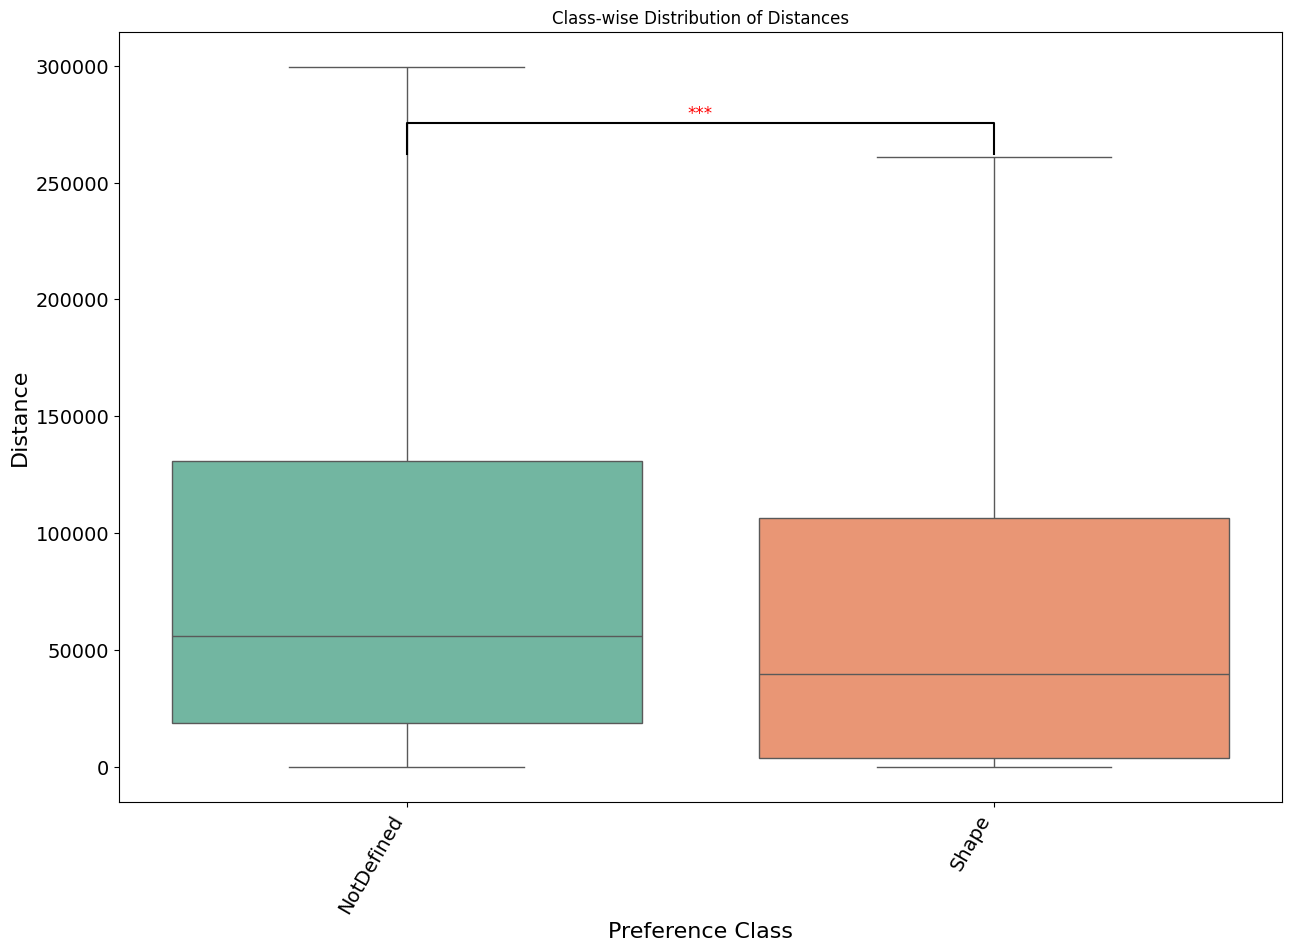

In [28]:
    # Plotting
    plt.figure(figsize=(15, 10))
    ax = plt.gca()

    sns.boxplot(x='Class_from_pref', y='Distance', hue='Class_from_pref', data=merged_data, palette='Set2', showfliers=False)

    # Perform statistical tests and annotate with p-values
    unique_groups = merged_data['Class_from_pref'].unique()
    box_positions = [0, 1, 2] 
    y_group = merged_data['Distance'].max() / 35
    gap_increment = (y_group / 10) 

    current_y = y_group
    for i, g1 in enumerate(unique_groups):
        for j, g2 in enumerate(unique_groups):
            if i < j:  # Compare each pair of TFs only once
                g1_data = merged_data[merged_data['Class_from_pref'] == g1]
                g2_data = merged_data[merged_data['Class_from_pref'] == g2]
                
                g1_distances = g1_data['Distance']
                g2_distances = g2_data['Distance']

                # Perform t-test
                stat, p_value = ttest_ind(g1_distances, g2_distances, equal_var=False)

                # Get significance stars based on p-value
                stars = get_significance_stars(p_value)
                if stars:  # Only annotate significant comparisons
                    add_stat_annotation(ax, box_positions[i], box_positions[j], current_y, p_value, stars, "red")
                    current_y += gap_increment

    plt.title(f'Class-wise Distribution of Distances')
    ax.set_xlabel('Preference Class', fontsize=16)  # X-axis label font size
    ax.set_ylabel('Distance', fontsize=16)  # Y-axis label font size

    # Adjust tick label font size
    ax.tick_params(axis='x', labelsize=14)  # X-axis tick labels font size
    ax.tick_params(axis='y', labelsize=14)
    plt.xticks(rotation=60, ha='right')

In [25]:
merged_data['Distance'].median() 

51643.0

In [30]:
plot_distances(sampled_data_first, tf_preferences, plot_output_folder, 'Domain regions')

Domain regions plot saved to /home/manisha/Desktop/shape_clusters/GM12878/domains/tf_distance_plots/


In [31]:
write_distance_statistics(sampled_data_first, tf_preferences, plot_output_folder, distance_type='first', n_instances=n)

Statistics for first distances written to /home/manisha/Desktop/shape_clusters/GM12878/domains/tf_distance_plots/first_10000_distance_statistics.txt
